In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib.lines import Line2D

In [3]:
from ecpaper_utils import fig_utils as figutils
from ecpaper_utils import linfit_utils as linfit

In [4]:
vwind_path = "../DATASORT/VWIND/DATA/"

### Read in data

In [5]:
vind5 = xr.open_dataset(vwind_path+"cmip5vwindindices.nc")
vind6 = xr.open_dataset(vwind_path+"cmip6vwindindices.nc")

pr5 = xr.open_dataset(vwind_path+"cmip5vwind_prdata.nc")
pr6 = xr.open_dataset(vwind_path+"cmip5vwind_prdata.nc")

u5 = xr.open_dataset(vwind_path+"u100_CMIP5.nc").rename({"__xarray_dataarray_variable__": "u100_diff"})
u6 = xr.open_dataset(vwind_path+"u100_CMIP6.nc").rename({"__xarray_dataarray_variable__": "u100_diff"})

In [6]:
vind5

<xarray.Dataset>
Dimensions:        (Model: 37)
Coordinates:
  * Model          (Model) object 'ACCESS1-0' 'ACCESS1-3' ... 'NorESM1-ME'
Data variables:
    vpastsw_em     (Model) float64 ...
    vfutsw_em      (Model) float64 ...
    vpastsw_1mem   (Model) float64 ...
    vfutsw_1mem    (Model) float64 ...
    vpastamp_em    (Model) float64 ...
    vpastamp_1mem  (Model) float64 ...

In [7]:
err5 = xr.open_dataset("../ERRORCALC/VWIND/DATA/errors_cmip5.nc")
err6 = xr.open_dataset("../ERRORCALC/VWIND/DATA/errors_cmip6.nc")

#### additional calculations for data in figure:

In [8]:
vind5['vsw_diff'] = vind5['vfutsw_em'] - vind5['vpastsw_em']
vind6['vsw_diff'] = vind6['vfutsw_em'] - vind6['vpastsw_em']

#### calculate regression models:  

In [9]:
## v amplitude as x variable
aols_vamp5, bols_vamp5 = linfit.linfit_xy(vind5["vpastamp_em"], vind5["vsw_diff"], sigma=err5["sig_vdiff"])
atls_vamp5, btls_vamp5 = linfit.tls(vind5["vpastamp_em"], vind5["vsw_diff"], err5["sig_psi"], err5["sig_vdiff"])
bhm_vamp5 = linfit.bhm(vind5["vpastamp_em"], vind5["vsw_diff"], err5["sig_psi"], err5["sig_vdiff"], 
                                    err5["r_psi_vdiff"], iseed = 3)
abhm_vamp5 = bhm_vamp5[0].mean()
bbhm_vamp5 = bhm_vamp5[1].mean()

aols_vamp6, bols_vamp6 = linfit.linfit_xy(vind6["vpastamp_em"], vind6["vsw_diff"], sigma=err6["sig_vdiff"])
atls_vamp6, btls_vamp6 = linfit.tls(vind6["vpastamp_em"], vind6["vsw_diff"], err6["sig_psi"], err6["sig_vdiff"])
bhm_vamp6 = linfit.bhm(vind6["vpastamp_em"], vind6["vsw_diff"], err6["sig_psi"], err6["sig_vdiff"], 
                                    err6["r_psi_vdiff"], iseed = 3)
abhm_vamp6 = bhm_vamp6[0].mean()
bbhm_vamp6 = bhm_vamp6[1].mean()

In [10]:
## change in u100 as x variable
aols_udiff5, bols_udiff5 = linfit.linfit_xy(u5["u100_diff"], vind5["vsw_diff"], sigma=err5["sig_vdiff"])
atls_udiff5, btls_udiff5 = linfit.tls(u5["u100_diff"], vind5["vsw_diff"], err5["sig_udiff"], err5["sig_vdiff"])
bhm_udiff5 = linfit.bhm(u5["u100_diff"], vind5["vsw_diff"], err5["sig_udiff"], err5["sig_vdiff"], 
                        err5["r_udiff_vdiff"], iseed = 3)
abhm_udiff5 = bhm_udiff5[0].mean()
bbhm_udiff5 = bhm_udiff5[1].mean()

aols_udiff6, bols_udiff6 = linfit.linfit_xy(u6["u100_diff"], vind6["vsw_diff"], sigma=err6["sig_vdiff"])
atls_udiff6, btls_udiff6 = linfit.tls(u6["u100_diff"], vind6["vsw_diff"], err6["sig_udiff"], err6["sig_vdiff"])
bhm_udiff6 = linfit.bhm(u6["u100_diff"], vind6["vsw_diff"], err6["sig_udiff"], err6["sig_vdiff"], 
                        err6["r_udiff_vdiff"], iseed = 3)
abhm_udiff6 = bhm_udiff6[0].mean()
bbhm_udiff6 = bhm_udiff6[1].mean()

In [11]:
## regression fit using u100 and psi as explanatory variables

aols_both5, b1ols_both5, b2ols_both5 = linfit.multi_ols(np.column_stack([vind5["vpastamp_em"], u5["u100_diff"]]), 
                                                        vind5["vsw_diff"], 
                                                        sigma = err5["sig_vdiff"])

aols_both6, b1ols_both6, b2ols_both6 = linfit.multi_ols(np.column_stack([vind6["vpastamp_em"], u6["u100_diff"]]), 
                                                        vind6["vsw_diff"], 
                                                        sigma = err6["sig_vdiff"])

#### observed data: 

In [12]:
obs_ds = xr.open_dataset(vwind_path+"vampobs.nc")

In [13]:
obs_vamp = pd.DataFrame({"label": ["ERA5", "ERA-Interim", "JRA-55", "MERRA2"], 
                         "vamp": [obs_ds["vamp_era5"].values, 
                                  obs_ds["vamp_erai"].values, 
                                  obs_ds["vamp_jra"].values, 
                                  obs_ds["vamp_merra"].values]})

obs_vamp

,label,vamp
0,ERA5,1.9170415342378517
1,ERA-Interim,1.8972887588371512
2,JRA-55,1.9550407020610128
3,MERRA2,1.92902143872452


#### set up figure: 

In [14]:
vlim = (-10, 2)
vticks = np.arange(-10, 4, 2)
psilim = (1,6)
ulim = (0, 12)
uticks = np.arange(0, 14, 2)
x_vamp = np.arange(1, 7, 1) # for plotting regression lines
x_u = np.arange(0, 13, 1)

In [15]:
obs_linestyles = ['solid', "dotted", "dashed", "dashdot"]

legendparts = [Line2D([0],[0], color='black', linestyle='solid', linewidth=2),
              Line2D([0],[0], color='black', linestyle='dotted', linewidth=2),
              Line2D([0],[0], color='black', linestyle='dashed', linewidth=2),
              Line2D([0],[0], color='black', linestyle='dashdot', linewidth=2),
              Line2D([0],[0], color='w', marker='o', markerfacecolor=figutils.cmip_col[0], markeredgecolor='black', markersize=10, markeredgewidth=2),
              Line2D([0],[0], color='w', marker='o', markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2),
              Line2D([0],[0], color=figutils.ols_col, linestyle='dashed', linewidth=3),
              Line2D([0],[0], color=figutils.tls_col, linestyle='dashed', linewidth=3),
              Line2D([0],[0], color=figutils.bhm_col, linestyle='dashed', linewidth=3)]

legendlabels=['ERA5','ERA-Interim','JRA-55','MERRA2','CMIP5','CMIP6','OLS','TLS','BHM']

In [16]:
plt.rc('axes', titlesize=16)     # fontsize of the axes titles (i.e. title of each panel)
plt.rc('axes', labelsize=14)    # fontsize of the x and y axis labels
plt.rc('xtick', labelsize=14)    # fontsize of the x tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the y tick labels

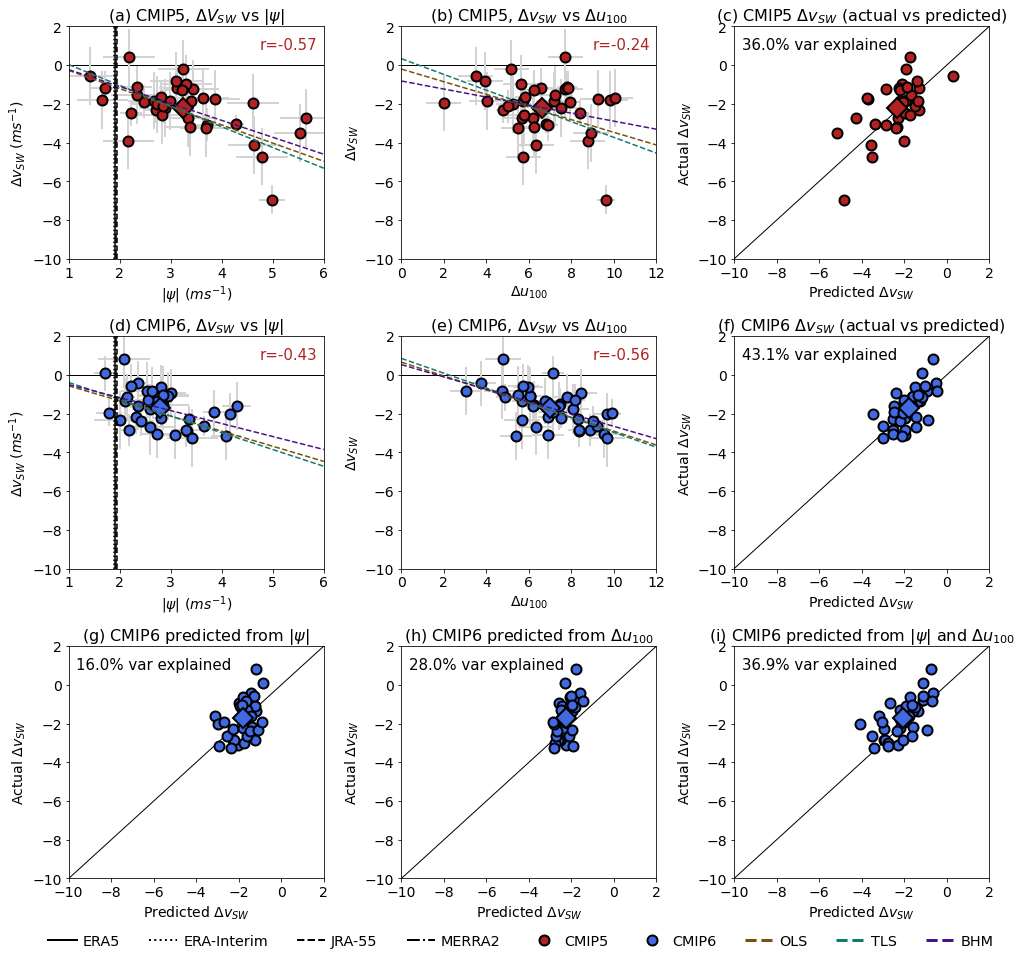

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (14, 13))

## panel a
ax = axes[0,0]
ax.set(ylim = vlim, xlim = psilim, title = "(a) CMIP5, $\Delta V_{SW}$ vs $|\psi|$", 
      xlabel = "$|\psi|$ $(ms^{-1})$", ylabel = "$\Delta v_{SW}$ $(ms^{-1})$")
ax.axhline(0, color = "black", linewidth = 1, zorder = 0)
ax.vlines(obs_vamp["vamp"], -10, 2, linestyles = obs_linestyles, color = "k", zorder = 5)
ax.plot(vind5["vpastamp_em"], vind5["vsw_diff"],"o", 
        markerfacecolor=figutils.cmip_col[0], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.plot(vind5["vpastamp_em"].mean(), vind5["vsw_diff"].mean(), "D", markerfacecolor=figutils.cmip_col[0], 
        markeredgecolor='black', markersize=14, markeredgewidth=2)
ax.errorbar(vind5["vpastamp_em"], vind5["vsw_diff"], 
            xerr = err5["sig_psi"]*1.96, 
            yerr = err5["sig_vdiff"]*1.96, 
            linestyle="None", color='lightgrey', linewidth=2)
ax.plot(x_vamp, x_vamp*bols_vamp5+aols_vamp5, linewidth = 1.5, linestyle = "dashed", color = figutils.ols_col)
ax.plot(x_vamp, x_vamp*btls_vamp5+atls_vamp5, linewidth = 1.5, linestyle = "dashed", color = figutils.tls_col)
ax.plot(x_vamp, x_vamp*bbhm_vamp5+abhm_vamp5, linewidth = 1.5, linestyle = "dashed", color = figutils.bhm_col)
ax.text(.75, .9, "r="+str(np.round(np.array(xr.corr(vind5["vpastamp_em"], vind5["vsw_diff"])), 2)), 
       transform = ax.transAxes, size = 15, color = figutils.cmip_col[0])

## panel b
ax = axes[0,1]
ax.set(ylim = vlim, xlim = ulim, xticks = uticks, title = "(b) CMIP5, $\Delta v_{SW}$ vs $\Delta u_{100}$", 
      ylabel = "$\Delta v_{SW}$", xlabel = "$\Delta u_{100}$")
ax.axhline(0, color = "black", linewidth = 1, zorder = 0)
ax.plot(u5["u100_diff"], vind5["vsw_diff"],"o", 
        markerfacecolor=figutils.cmip_col[0], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.plot(u5["u100_diff"].mean(), vind5["vsw_diff"].mean(), "D", markerfacecolor=figutils.cmip_col[0], 
        markeredgecolor='black', markersize=14, markeredgewidth=2)
ax.errorbar(u5["u100_diff"], vind5["vsw_diff"], 
            xerr = err5["sig_udiff"]*1.96, 
            yerr = err5["sig_vdiff"]*1.96, 
            linestyle="None", color='lightgrey', linewidth=2)
ax.plot(x_u, x_u*bols_udiff5+aols_udiff5, linewidth = 1.5, linestyle = "dashed", color = figutils.ols_col)
ax.plot(x_u, x_u*btls_udiff5+atls_udiff5, linewidth = 1.5, linestyle = "dashed", color = figutils.tls_col)
ax.plot(x_u, x_u*bbhm_udiff5+abhm_udiff5, linewidth = 1.5, linestyle = "dashed", color = figutils.bhm_col)
ax.text(.75, .9, "r="+str(np.round(np.array(xr.corr(u5["u100_diff"], vind5["vsw_diff"])), 2)), 
       transform = ax.transAxes, size = 15, color = figutils.cmip_col[0])

## panel c
ax = axes[0,2]
ax.set(ylim = vlim, xlim = vlim, xticks = vticks, title = "(c) CMIP5 $\Delta v_{SW}$ (actual vs predicted)", 
      xlabel = "Predicted $\Delta v_{SW}$", ylabel = "Actual $\Delta v_{SW}$")
ax.plot(vlim, vlim, color = "k", linewidth = 1, zorder = 0)
x = vind5["vpastamp_em"]*b1ols_both5 + u5["u100_diff"]*b2ols_both5 + aols_both5
y = vind5["vsw_diff"]
varexplained = ((np.var(y) - np.var(y-x))/np.var(y)).values*100
ax.plot(x, y, "o", markerfacecolor=figutils.cmip_col[0], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.text(.03, .9, str(np.round(varexplained, 1))+"% var explained", 
       transform = ax.transAxes, size = 15)
ax.plot(x.mean(), y.mean(), "D", markerfacecolor=figutils.cmip_col[0], markeredgecolor='black', markersize=14, markeredgewidth=2)

## panel d
ax = axes[1,0]
ax.set(ylim = vlim, xlim = psilim, title = "(d) CMIP6, $\Delta v_{SW}$ vs $|\psi|$", 
       xlabel = "$|\psi|$ $(ms^{-1})$", ylabel = "$\Delta v_{SW}$ $(ms^{-1})$")
ax.axhline(0, color = "black", linewidth = 1, zorder = 0)
ax.vlines(obs_vamp["vamp"], -10, 2, linestyles = obs_linestyles, color = "k", zorder = 5)
ax.plot(vind6["vpastamp_em"], vind6["vsw_diff"],"o", 
        markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.plot(vind6["vpastamp_em"].mean(), vind6["vsw_diff"].mean(), "D", markerfacecolor=figutils.cmip_col[1], 
        markeredgecolor='black', markersize=14, markeredgewidth=2)
ax.errorbar(vind6["vpastamp_em"], vind6["vsw_diff"], 
            xerr = err6["sig_psi"]*1.96, 
            yerr = err6["sig_vdiff"]*1.96, 
            linestyle="None", color='lightgrey', linewidth=2)
ax.plot(x_vamp, x_vamp*bols_vamp6+aols_vamp6, linewidth = 1.5, linestyle = "dashed", color = figutils.ols_col)
ax.plot(x_vamp, x_vamp*btls_vamp6+atls_vamp6, linewidth = 1.5, linestyle = "dashed", color = figutils.tls_col)
ax.plot(x_vamp, x_vamp*bbhm_vamp6+abhm_vamp6, linewidth = 1.5, linestyle = "dashed", color = figutils.bhm_col)
ax.text(.75, .9, "r="+str(np.round(np.array(xr.corr(vind6["vpastamp_em"], vind6["vsw_diff"])), 2)), 
       transform = ax.transAxes, size = 15, color = figutils.cmip_col[0])


## panel e
ax = axes[1,1]
ax.set(ylim = vlim, xlim = ulim, xticks = uticks, title = "(e) CMIP6, $\Delta v_{SW}$ vs $\Delta u_{100}$", 
      ylabel = "$\Delta v_{SW}$", xlabel = "$\Delta u_{100}$")
ax.axhline(0, color = "black", linewidth = 1, zorder = 0)
ax.plot(u6["u100_diff"], vind6["vsw_diff"],"o", 
        markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.plot(u6["u100_diff"].mean(), vind6["vsw_diff"].mean(), "D", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=14, markeredgewidth=2)
ax.errorbar(u6["u100_diff"], vind6["vsw_diff"], 
            xerr = err6["sig_udiff"]*1.96, 
            yerr = err6["sig_vdiff"]*1.96, 
            linestyle="None", color='lightgrey', linewidth=2)
ax.plot(x_u, x_u*bols_udiff6+aols_udiff6, linewidth = 1.5, linestyle = "dashed", color = figutils.ols_col)
ax.plot(x_u, x_u*btls_udiff6+atls_udiff6, linewidth = 1.5, linestyle = "dashed", color = figutils.tls_col)
ax.plot(x_u, x_u*bbhm_udiff6+abhm_udiff6, linewidth = 1.5, linestyle = "dashed", color = figutils.bhm_col)
ax.text(.75, .9, "r="+str(np.round(np.array(xr.corr(u6["u100_diff"], vind6["vsw_diff"])), 2)), 
       transform = ax.transAxes, size = 15, color = figutils.cmip_col[0])

## panel f
ax = axes[1,2]
ax.set(ylim = vlim, xlim = vlim, xticks = vticks, title = "(f) CMIP6 $\Delta v_{SW}$ (actual vs predicted)", 
        xlabel = "Predicted $\Delta v_{SW}$", ylabel = "Actual $\Delta v_{SW}$")
ax.plot(vlim, vlim, color = "k", linewidth = 1, zorder = 0)
x = vind6["vpastamp_em"]*b1ols_both6 + u6["u100_diff"]*b2ols_both6 + aols_both6
y = vind6["vsw_diff"]
varexplained = ((np.var(y) - np.var(y-x))/np.var(y)).values*100
ax.plot(x, y, "o", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.text(.03, .9, str(np.round(varexplained, 1))+"% var explained", 
       transform = ax.transAxes, size = 15)
ax.plot(x.mean(), y.mean(), "D", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=14, markeredgewidth=2)

## panel g
ax = axes[2,0]
ax.set(ylim = vlim, xlim = vlim, xticks = vticks, title = "(g) CMIP6 predicted from $|\psi|$", 
        xlabel = "Predicted $\Delta v_{SW}$", ylabel = "Actual $\Delta v_{SW}$")
ax.plot(vlim, vlim, color = "k", linewidth = 1, zorder = 0)
x = vind6["vpastamp_em"]*bbhm_vamp5 + abhm_vamp5
y = vind6["vsw_diff"]
varexplained = ((np.var(y) - np.var(y-x))/np.var(y)).values*100
ax.plot(x, y, "o", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.text(.03, .9, str(np.round(varexplained, 1))+"% var explained", 
       transform = ax.transAxes, size = 15)
ax.plot(x.mean(), y.mean(), "D", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=14, markeredgewidth=2)

## panel h
ax = axes[2,1]
ax.set(ylim = vlim, xlim = vlim, xticks = vticks, title = "(h) CMIP6 predicted from $\Delta u_{100}$", 
        xlabel = "Predicted $\Delta v_{SW}$", ylabel = "Actual $\Delta v_{SW}$")
ax.plot(vlim, vlim, color = "k", linewidth = 1, zorder = 0)
x = u6["u100_diff"]*bbhm_udiff5 + abhm_udiff5
y = vind6["vsw_diff"]
varexplained = ((np.var(y) - np.var(y-x))/np.var(y)).values*100
ax.plot(x, y,"o", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.text(.03, .9, str(np.round(varexplained, 1))+"% var explained", 
       transform = ax.transAxes, size = 15)
ax.plot(x.mean(), y.mean(), "D", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=14, markeredgewidth=2)

## panel i
ax = axes[2,2]
ax.set(ylim = vlim, xlim = vlim, xticks = vticks, title = "(i) CMIP6 predicted from $|\psi|$ and $\Delta u_{100}$", 
        xlabel = "Predicted $\Delta v_{SW}$", ylabel = "Actual $\Delta v_{SW}$")
ax.plot(vlim, vlim, color = "k", linewidth = 1, zorder = 0)
x = vind6["vpastamp_em"]*b1ols_both5 + u6["u100_diff"]*b2ols_both5 + aols_both5
y = vind6["vsw_diff"]
varexplained = ((np.var(y) - np.var(y-x))/np.var(y)).values*100
ax.plot(x, y, "o", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=10, markeredgewidth=2)
ax.text(.03, .9, str(np.round(varexplained, 1))+"% var explained", 
       transform = ax.transAxes, size = 15)
ax.plot(x.mean(), y.mean(), "D", markerfacecolor=figutils.cmip_col[1], markeredgecolor='black', markersize=14, markeredgewidth=2)
fig.legend(legendparts, legendlabels, handletextpad = 0.4, bbox_to_anchor = (0.52, -.01), 
           loc = 'center', ncol=9, frameon = False, fontsize='x-large')

plt.tight_layout()

In [18]:
fig.savefig('fig7.png', bbox_inches = "tight", facecolor = "white")